# Santander Customer Transaction Prediction Analysis and Modeling

This notebook performs an end-to-end analysis and modeling for the Santander Customer Transaction Prediction dataset. It includes data loading, exploratory data analysis (EDA), preprocessing, and the implementation of a robust ensemble model using XGBoost, LightGBM, and CatBoost.

## **1. Data Loading**

- We begin by loading the train and test datasets using pandas.

In [1]:
import pandas as pd

# Load Data
train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

## **2. Exploratory Data Analysis (EDA)**

#### 2.1 Dataset Overview

- Display dataset structure using info().

- Sample the first few rows using head().

In [2]:
# Overview of dataset
print("Train Dataset Overview:")
print(train.info())
print("\nTest Dataset Overview:")
print(test.info())

# Check the first few rows of the train dataset
print("\nTrain Dataset Sample:")
print(train.head())

Train Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None

Test Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None

Train Dataset Sample:
   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \

#### 2.2 Target Variable Distribution

- Check the class distribution of the target variable using value_counts().

- Visualize the distribution with a count plot.


Target Distribution:
target
0    0.89951
1    0.10049
Name: proportion, dtype: float64


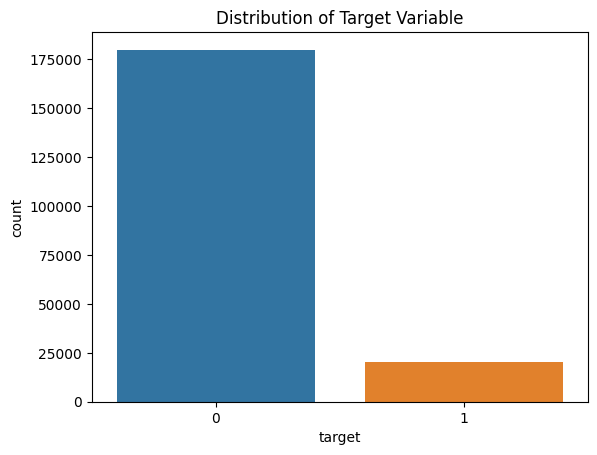

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the distribution of the target variable
print("\nTarget Distribution:")
print(train['target'].value_counts(normalize=True))

# Visualize target distribution
sns.countplot(data=train, x='target')
plt.title("Distribution of Target Variable")
plt.show()

#### 2.3 Summary Statistics

- Generate descriptive statistics with describe().

- Count unique values for each feature.

In [4]:
# Generate descriptive statistics
print("\nDescriptive Statistics for Train Dataset:")
print(train.describe())

# Check for unique values in features
unique_counts = train.drop(columns=['ID_code', 'target']).nunique().sort_values()
print("\nUnique Values Per Column:")
print(unique_counts)


Descriptive Statistics for Train Dataset:
              target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.

#### 2.4 Missing Values

- Check for missing values in both datasets.

In [5]:
# Check for missing values
print("\nMissing Values in Train Dataset:")
print(train.isnull().sum().sum())

print("\nMissing Values in Test Dataset:")
print(test.isnull().sum().sum())


Missing Values in Train Dataset:
0

Missing Values in Test Dataset:
0


#### 2.5 Feature Distribution

- Visualize the distribution of all features (excluding ID_code and target) using histograms.

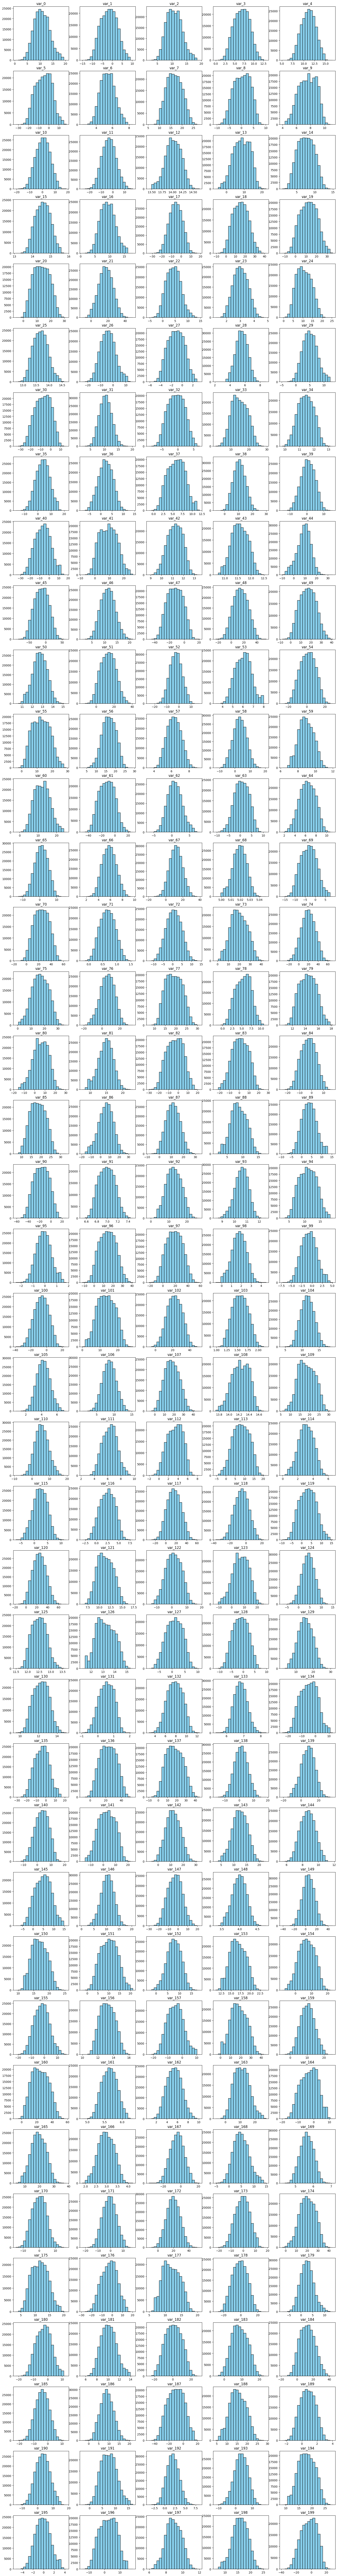

In [6]:
import matplotlib.pyplot as plt

# Exclude 'ID_code' and 'target' columns
feature_columns = [col for col in train.columns if col not in ['ID_code', 'target']]

# Define the number of rows and columns for subplots
n_features = len(feature_columns)
n_cols = 5  
n_rows = (n_features + n_cols - 1) // n_cols  

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot histograms for each feature
for i, feature in enumerate(feature_columns):
    axes[i].hist(train[feature], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(feature)

# Hide unused subplots
for i in range(len(feature_columns), len(axes)):
    axes[i].axis('off')

plt.show()

## **3. Correlation Analysis**

- Compute pairwise correlations and visualize with a heatmap.

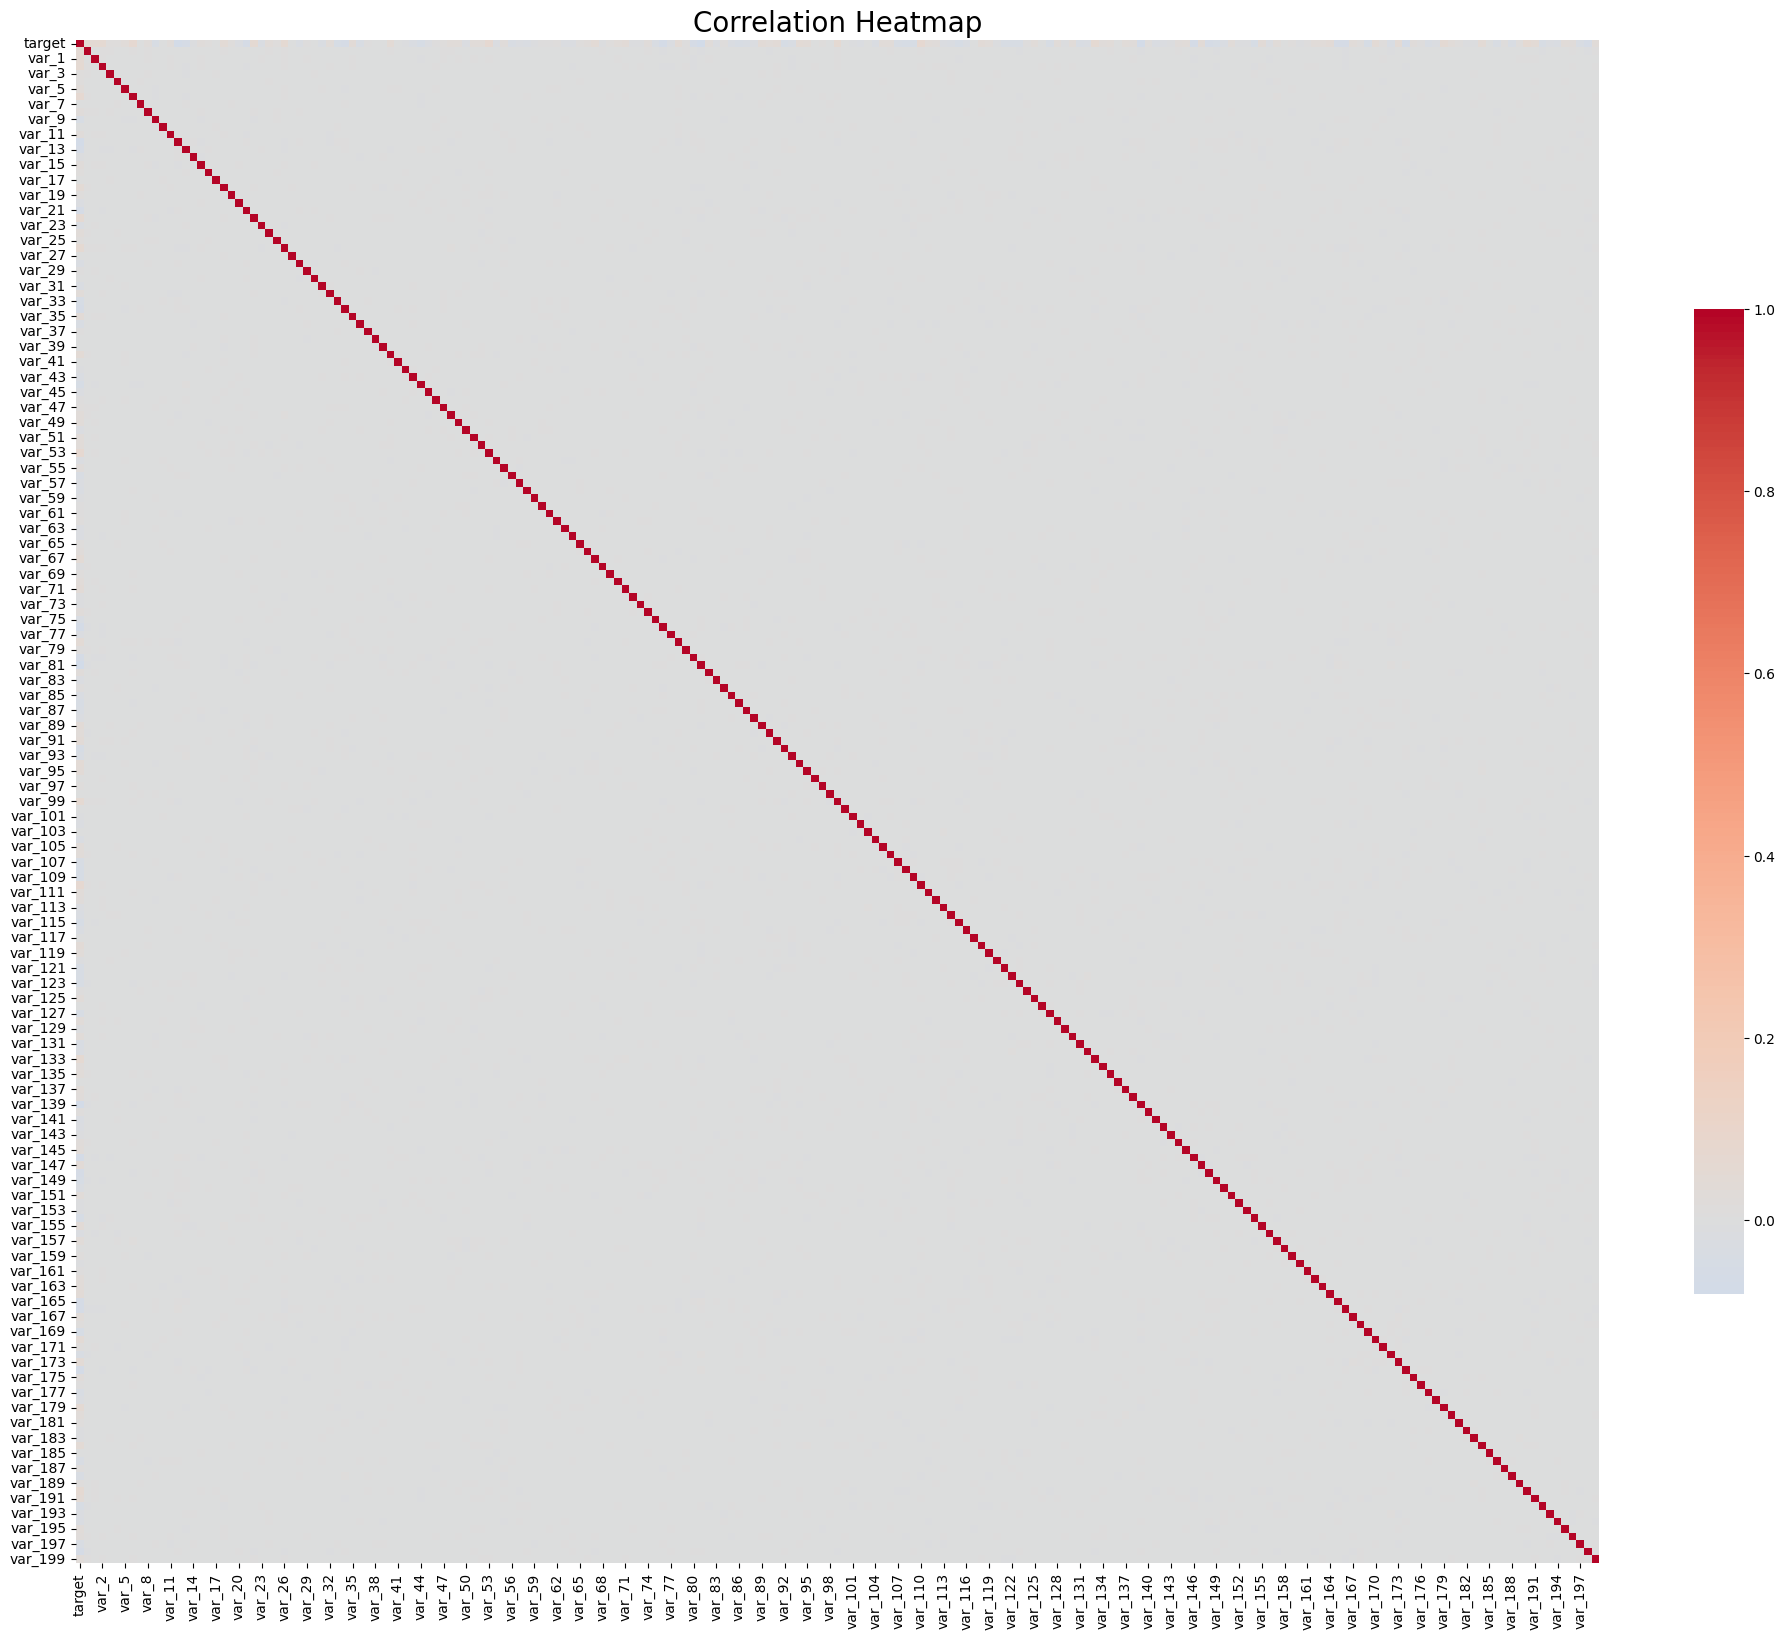

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations
correlation_matrix = train.drop(columns=['ID_code']).corr()

# Visualize the correlation matrix 
plt.figure(figsize=(20, 20))  
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'shrink': 0.5}, 
    annot=False  
)
plt.title("Correlation Heatmap", fontsize=20)
plt.xticks(fontsize=10, rotation=90)  
plt.yticks(fontsize=10, rotation=0)   
plt.tight_layout()
plt.show()

## **4. Univariate Analysis**

- Perform density plot analysis for all feature variables.

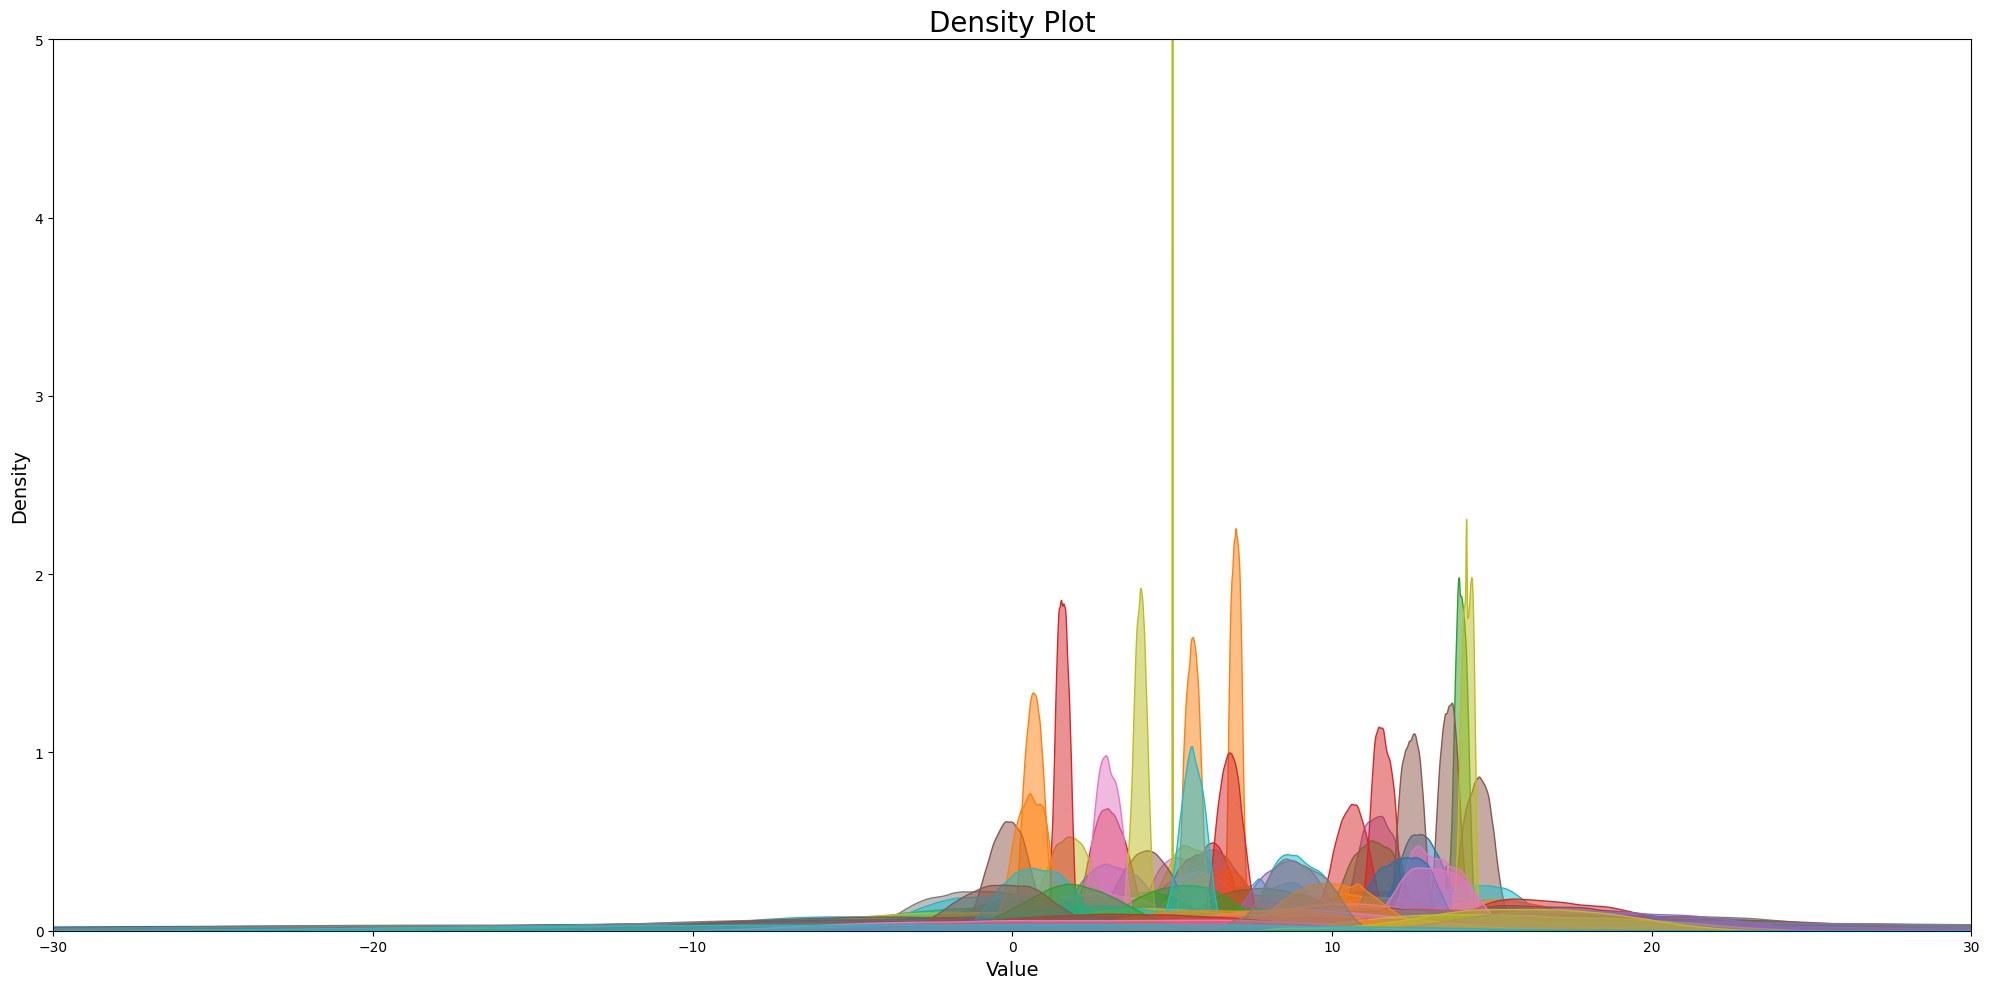

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Extract all 'var_' columns
var_columns = [col for col in train.columns if col.startswith('var_')]

# Set up the figure
plt.figure(figsize=(20, 10))
plt.title("Density Plot", fontsize=20)

# Loop through all variables and plot densities
for var in var_columns:
    sns.kdeplot(train[var], label=var, fill=True, alpha=0.5)

# Customize the zoom (focus on the range with data)
plt.xlim(-30, 30) 
plt.ylim(0, 5)  

# Customize labels and legend
plt.xlabel("Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()
plt.show()

## **5. Feature Importance by Target**

- Visualize density comparisons of features for each target class.

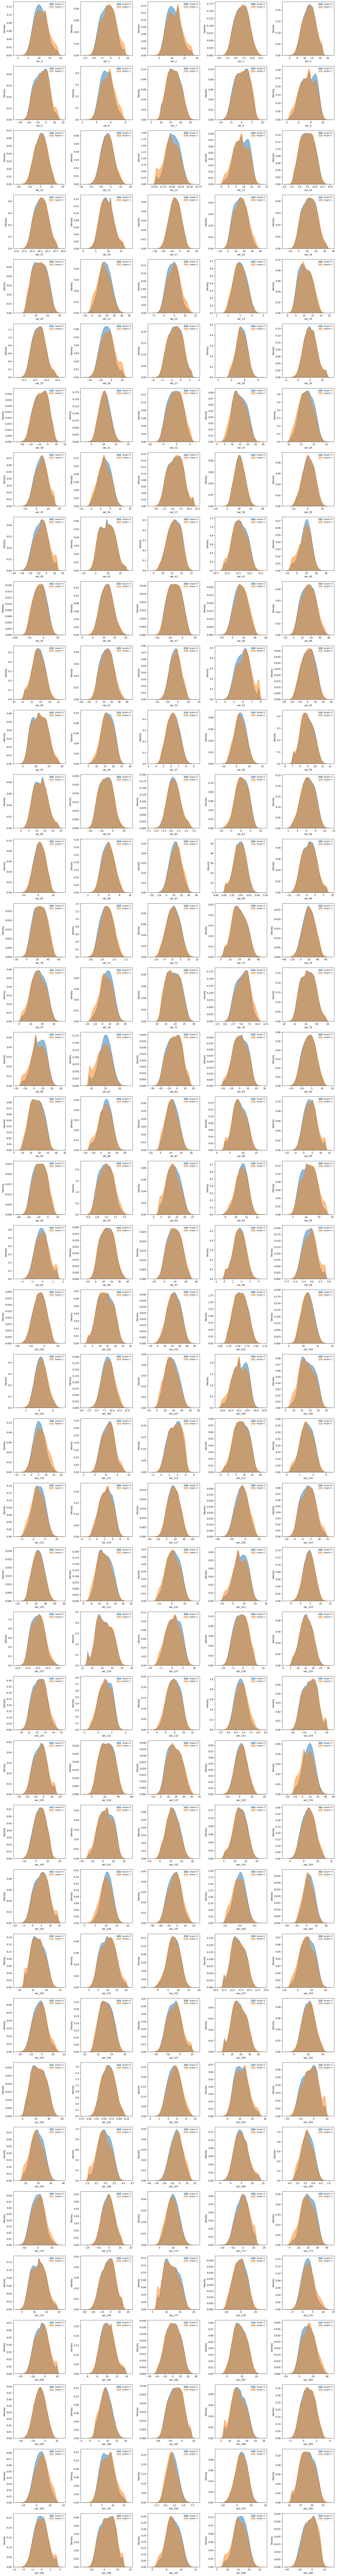

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract all 'var_' columns
var_columns = [col for col in train.columns if col.startswith('var_')]

# Define the number of rows and columns for subplots
n_features = len(var_columns)
n_cols = 5  
n_rows = (n_features + n_cols - 1) // n_cols  

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot density plots for each feature
for i, feature in enumerate(var_columns):
    sns.kdeplot(data=train[train['target'] == 0], x=feature, label='target=0', shade=True, alpha=0.5, ax=axes[i])
    sns.kdeplot(data=train[train['target'] == 1], x=feature, label='target=1', shade=True, alpha=0.5, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel("Density", fontsize=10)
    axes[i].legend(fontsize=8)

# Hide any unused subplots
for i in range(len(var_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
plt.show()

## **6. Advanced Statistical Analysis**

#### 6.1 Skewness and Kurtosis

- Compute skewness and kurtosis for all features.

In [10]:
from scipy.stats import skew, kurtosis

# Compute skewness and kurtosis
skewness = train.drop(columns=['ID_code', 'target']).apply(skew).sort_values()
kurtosis_vals = train.drop(columns=['ID_code', 'target']).apply(kurtosis).sort_values()

print("\nSkewness of Features:")
print(skewness)

print("\nKurtosis of Features:")
print(kurtosis_vals)


Skewness of Features:
var_44    -0.340170
var_93    -0.238089
var_81    -0.232524
var_80    -0.220234
var_86    -0.216857
             ...   
var_163    0.234778
var_0      0.235637
var_179    0.242889
var_2      0.260312
var_168    0.267412
Length: 200, dtype: float64

Kurtosis of Features:
var_20    -0.811812
var_177   -0.805291
var_8     -0.803609
var_77    -0.802857
var_160   -0.773910
             ...   
var_168   -0.200463
var_146   -0.168057
var_93    -0.152392
var_44    -0.096492
var_179   -0.013994
Length: 200, dtype: float64


#### 6.2 Outlier Analysis

- Visualize outliers with boxplots for selected features.

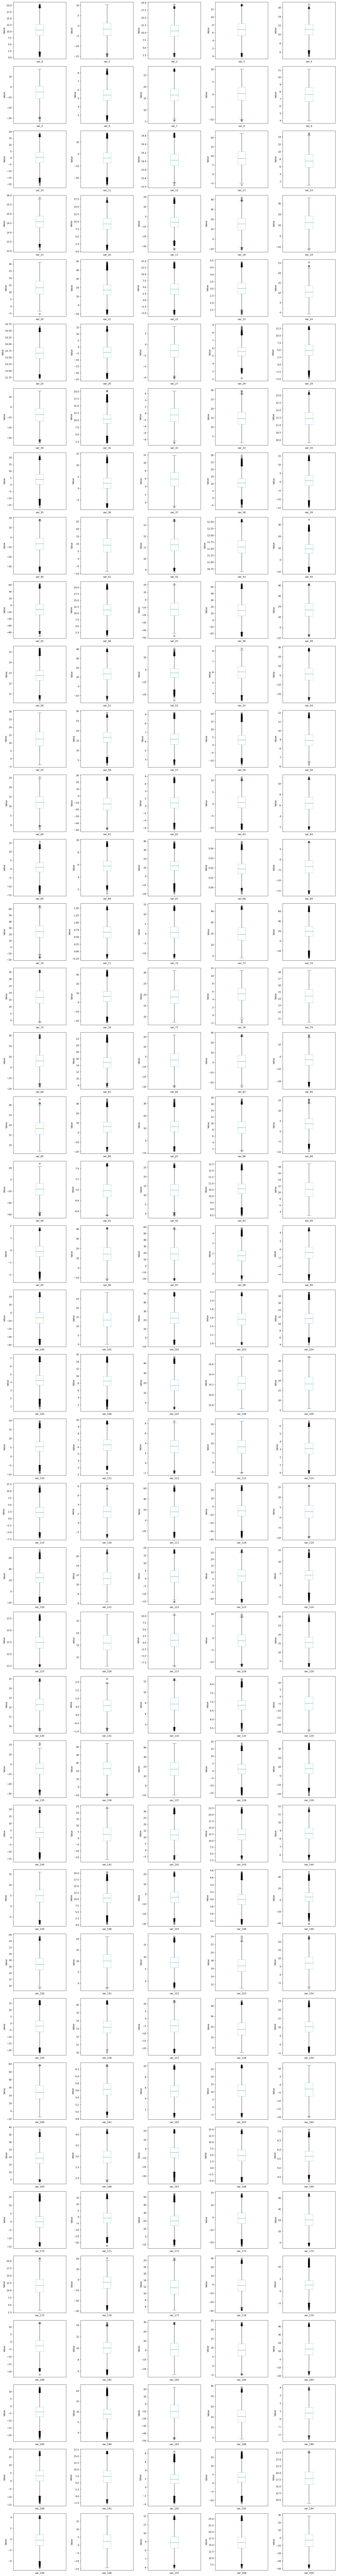

In [11]:
import matplotlib.pyplot as plt

# Extract all 'var_' columns
var_columns = [col for col in train.columns if col.startswith('var_')]

# Define the number of rows and columns for subplots
n_features = len(var_columns)
n_cols = 5 
n_rows = (n_features + n_cols - 1) // n_cols 

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot boxplots for each feature
for i, feature in enumerate(var_columns):
    train[[feature]].plot(kind='box', ax=axes[i], color={'boxes': 'skyblue', 'whiskers': 'black'})
    axes[i].set_ylabel("Value")

# Hide unused subplots
for i in range(len(var_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout
plt.show()

## **8. Machine Learning Model**

#### 8.1 Preprocessing

- Standardize features using StandardScaler.
- Apply PCA to reduce dimensionality while retaining 90% variance.
- Handle class imbalance with SMOTE.
  
#### 8.2 Cross-Validation

- Use StratifiedKFold with 3 folds for model validation.

#### 8.3 Hyperparameter Optimization

- Use RandomizedSearchCV to tune hyperparameters for:
    - XGBoost
    - LightGBM
    - CatBoost

#### 8.4 Ensemble Voting Classifier

- Combine the optimized models using a weighted soft voting approach, with weights derived from individual model AUC scores.

#### 8.5 Final Prediction

- Train the ensemble model on the resampled dataset.
- Generate predictions on the test dataset and save them in a CSV file.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Load dataset
train_data = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test_data = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')

# Separate features and target
X = train_data.drop(columns=['ID_code', 'target'])
y = train_data['target']
X_test = test_data.drop(columns=['ID_code'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.90) 
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Handle imbalance with SMOTE 
smote = SMOTE(random_state=42)  
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Cross-validation setup 
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter grids for RandomizedSearchCV
xgb_param_grid = {
    'learning_rate': stats.uniform(0.01, 0.1),
    'max_depth': stats.randint(3, 6),
    'n_estimators': stats.randint(50, 100), 
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4)
}

lgb_param_grid = {
    'learning_rate': stats.uniform(0.01, 0.1),
    'max_depth': stats.randint(3, 6),
    'n_estimators': stats.randint(50, 100), 
    'num_leaves': stats.randint(20, 100),
    'subsample': stats.uniform(0.6, 0.4),
    'colsample_bytree': stats.uniform(0.6, 0.4)
}

catboost_param_grid = {
    'learning_rate': stats.uniform(0.01, 0.04),  
    'depth': stats.randint(3, 5),                 
    'iterations': stats.randint(50, 100),         
    'l2_leaf_reg': stats.uniform(0.1, 2),        
    'border_count': stats.randint(32, 48)         
}

# Use RandomizedSearchCV for more efficient search 
xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42, use_label_encoder=False),
    param_distributions=xgb_param_grid,
    n_iter=3,  
    cv=skf,
    scoring='roc_auc',
    n_jobs=1,  
    random_state=42
)
xgb_search.fit(X_resampled, y_resampled)

lgb_search = RandomizedSearchCV(
    lgb.LGBMClassifier(device='cpu', random_state=42),  
    param_distributions=lgb_param_grid,
    n_iter=3,  
    cv=skf,
    scoring='roc_auc',
    n_jobs=1,  
    random_state=42
)
lgb_search.fit(X_resampled, y_resampled)

catboost_search = RandomizedSearchCV(
    CatBoostClassifier(task_type='CPU', verbose=0, random_state=42),  
    param_distributions=catboost_param_grid,
    n_iter=3,  
    cv=skf,
    scoring='roc_auc',
    n_jobs=1,  
    random_state=42
)
catboost_search.fit(X_resampled, y_resampled)

# Retrieve best models
best_xgb_model = xgb_search.best_estimator_
best_lgb_model = lgb_search.best_estimator_
best_catboost_model = catboost_search.best_estimator_

# Weighted voting classifier based on individual model performance
weights = [
    roc_auc_score(y_resampled, best_xgb_model.predict_proba(X_resampled)[:, 1]),
    roc_auc_score(y_resampled, best_lgb_model.predict_proba(X_resampled)[:, 1]),
    roc_auc_score(y_resampled, best_catboost_model.predict_proba(X_resampled)[:, 1])
]

voting_model = VotingClassifier(
    estimators=[
        ('xgb', best_xgb_model),
        ('lgb', best_lgb_model),
        ('catboost', best_catboost_model)
    ],
    voting='soft',
    weights=weights
)

# Train final voting model
voting_model.fit(X_resampled, y_resampled)

# Predict on test data
predictions = voting_model.predict_proba(X_test_pca)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'ID_code': test_data['ID_code'],
    'target': predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")

[LightGBM] [Info] Number of positive: 119935, number of negative: 119934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45645
[LightGBM] [Info] Number of data points in the train set: 239869, number of used features: 179
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000008
[LightGBM] [Info] Start training from score 0.000008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 